In [0]:
# !pip install category_encoders
import category_encoders as ce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
train_features = pd.read_csv('https://raw.githubusercontent.com/PWalis/Unit-2-Project/master/train_features.csv')
train_features.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
id,69572,8776,34310,67743,19728,9944,19816,54551,53934,46144,49056,50409,36957,50495,53752,61848,48451,58155,34169,18274,48375,6091,58500,37862,51058,22308,55012,20145,19685,69124,46804,6696,57238,12402,41583,57355,67359,60048,16583,25,70238,12796,52019,19282,1843,12958,45111,13620,18864,25182
amount_tsh,6000,0,25,0,0,20,0,0,0,0,0,200,0,0,0,0,500,0,0,500,200,0,0,500,0,0,500,0,0,0,0,50,0,0,0,0,0,0,4000,0,25,500,500,0,20,0,20,0,4000,1500
date_recorded,2011-03-14,2013-03-06,2013-02-25,2013-01-28,2011-07-13,2011-03-13,2012-10-01,2012-10-09,2012-11-03,2011-08-03,2011-02-20,2013-02-18,2012-10-14,2013-03-15,2012-10-20,2011-08-04,2011-07-04,2011-09-04,2011-07-22,2011-02-22,2011-02-27,2013-02-10,2011-10-04,2013-11-03,2013-01-21,2013-02-25,2013-01-16,2011-07-11,2013-03-05,2013-03-16,2011-03-23,2011-03-16,2013-03-19,2011-03-11,2011-02-23,2013-03-28,2011-07-16,2011-03-27,2011-02-20,2013-02-11,2013-10-03,2011-03-12,2011-07-07,2013-01-15,2013-03-18,2012-10-22,2013-02-05,2011-07-27,2011-02-20,2011-04-04
funder,Roman,Grumeti,Lottery Club,Unicef,Action In A,Mkinga Distric Coun,Dwsp,Rwssp,Wateraid,Isingiro Ho,Private,Danida,World Vision,Lawatefuka Water Supply,Biore,Rudep,Unicef,Unicef,Hesawa,Danida,Twe,Dwsp,Unicef,Isf,African Development Bank,Government Of Tanzania,Sobodo,Hesawa,Government Of Tanzania,Lawatefuka Water Supply,Water,Private Individual,Government Of Tanzania,Undp,NaN,Not Known,Danida,Kirde,Cefa,Government Of Tanzania,Ces(gmbh),Government Of Tanzania,European Union,NaN,Government Of Tanzania,World Vision,Lga,NaN,Cefa,District Council
gps_height,1390,1399,686,263,0,0,0,0,0,0,62,1062,0,1368,0,1645,1703,1656,1162,1763,2216,0,1510,672,1645,1273,200,0,1443,1256,0,180,1481,1638,-41,1546,0,0,1955,1348,710,2469,1803,1642,1007,0,240,0,1982,2169
installer,Roman,GRUMETI,World vision,UNICEF,Artisan,DWE,DWSP,DWE,Water Aid,Artisan,Private,DANIDA,World vision,Lawatefuka water sup,WEDECO,DWE,DWE,DWE,DWE,Danid,TWE,DWE,DWE,ISF,DWE,DWE,Kilolo Star,DWE,District council,Lawatefuka water sup,Water,WU,DWE,DWE,NaN,Not known,Central government,DWE,CEFA,DWE,DWE,Commu,Accra,NaN,DWE,World Vision,LGA,NaN,CEFA,DWE
longitude,34.9381,34.6988,37.4607,38.4862,31.1308,39.1728,33.3624,32.6206,32.7111,30.627,39.2095,35.7703,33.7981,37.0926,34.3641,31.4441,34.6424,34.5693,32.9202,34.509,34.4734,0,34.5869,37.94,29.7471,37.4228,39.3708,31.1043,37.6111,37.0617,36.1083,38.3636,37.4923,34.4784,39.8129,36.6187,33.8543,35.8584,35.8903,30.6133,37.42,33.9279,34.8146,34.9678,36.8061,33.3453,39.0874,33.5406,35.8714,34.4413
latitude,-9.85632,-2.14747,-3.82133,-11.1553,-1.82536,-4.76559,-3.76636,-4.2262,-5.14671,-1.25705,-7.03414,-10.5742,-3.29019,-3.18178,-3.62933,-8.27496,-9.10618,-9.08551,-1.94787,-9.89441,-9.59499,-2e-08,-8.98001,-4.12559,-4.49557,-3.31754,-9.94253,-1.73536,-3.26353,-3.19199,-5.791,-6.6361,-3.29063,-9.71591,-7.88999,-3.293,-9.63852,-4.64791,-8.2244,-3.89456,-3.47685,-9.20465,-9.0325,-4.62892,-3.47856,-3.839,-11.0006,-9.1729,-8.22756,-9.18988
wpt_name,none,Zahanati,Kwa Mahundi,Zahanati Ya Nanyumbu,Shuleni,Tajiri,Kwa Ngomho,Tushirikiane,Kwa Ramadhan Musa,Kwapeto,Mzee Hokororo,Kwa Alid Nchimbi,Pamba,Kwa John Izack Mmari,Mwabasabi,Kwa Juvenal Ching'Ombe,Kwa John Mtenzi,Kwa Rose Chaula,Ngomee,none,none,Muungano,Shuleni,Kinonga,Kamsasa,Kwa Tukai,Ruhoma Primary School,Kwawilliam,Kwa Kibakaya,Kwa Willium Kinda,Ngosi,Kituo Cha Maziwa,Kwa Philip Lyimo,none,Msikitini Wa Ijumaa,Sekondari,Office Ya Kijiji,Tangi,none,Mkuyuni,Kwa Lusina,none,Zahanati-Misssion,Mvae Primary,Kwa Bariki,Shimasa,Mikoroshini,Mahakamani,none,Kwa Bryson Msigwa
num_private,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
train_labels = pd.read_csv('https://raw.githubusercontent.com/PWalis/Unit-2-Project/master/train_labels.csv')
train_labels.shape

(59400, 2)

In [37]:
test_features = pd.read_csv('https://raw.githubusercontent.com/PWalis/Unit-2-Project/master/test_features.csv')
test_features.shape

(14358, 40)

In [0]:
X = train_features
y = train_labels.drop('id', axis=1)

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
def wrangle(x):
  x = x.copy()
  #Exposing the nan values
  x['gps_height'].replace(0.0, np.nan, inplace=True)
  x['population'].replace(0.0, np.nan, inplace=True)
  x['amount_tsh'].replace(0.0, np.nan, inplace=True)
  x['longitude'].replace(0.0, np.nan, inplace=True)
  x['latitude'].replace(0.0, np.nan, inplace=True)
 # Getting gps height using other features and the means of those gps heights, some rows don't have all the features to group by so 
 # getting the heights from a broader group then lastly filling in nan with gps height mean
  x['gps_height'].fillna(x.groupby(['region', 'district_code'])['gps_height'].transform('mean'), inplace=True)
  x['gps_height'].fillna(x.groupby(['region'])['gps_height'].transform('mean'), inplace=True)
  x['gps_height'].fillna(x['gps_height'].mean(), inplace=True)
 # same strategy for population
  x['population'].fillna(x.groupby(['region', 'district_code'])['population'].transform('median'), inplace=True)
  x['population'].fillna(x.groupby(['region'])['population'].transform('median'), inplace=True)
  x['population'].fillna(x['population'].median(), inplace=True)
 # same strategy for amount_tsh
  x['amount_tsh'].fillna(x.groupby(['region', 'district_code'])['amount_tsh'].transform('median'), inplace=True)
  x['amount_tsh'].fillna(x.groupby(['region'])['amount_tsh'].transform('median'), inplace=True)
  x['amount_tsh'].fillna(x['amount_tsh'].median(), inplace=True)
 # similar strategy  for longitude and latitude
  x['longitude'].fillna(x.groupby(['region', 'district_code'])['longitude'].transform('mean'), inplace=True)
  x['latitude'].fillna(x.groupby(['region', 'district_code'])['latitude'].transform('mean'), inplace=True)
  x['longitude'].fillna(x.groupby(['region'])['longitude'].transform('mean'), inplace=True)
  
 # Ridding construction year nan
  x['construction_year'].fillna(x.groupby(['region', 'district_code'])['construction_year'].transform('median'), inplace=True)
  x['construction_year'].fillna(x.groupby(['region'])['construction_year'].transform('median'), inplace=True)
  x['construction_year'].fillna(x.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
  x['construction_year'].fillna(x['construction_year'].median(), inplace=True)
 # making a new feature using the date recorded and date built to get years of survice
  dates = pd.to_datetime(x['date_recorded'])
  x['years_service'] = dates.dt.year - x.construction_year
  

  x['scheme_management'].fillna('other', inplace=True)
  x['installer'].fillna('other', inplace=True)
 # water per person feature created using amount_tsh divided by population 
  x['water_per_person'] = x['amount_tsh']/x['population']
 # Making all strings lowercase to avoid unneccesary encoding cardinality 
  x['waterpoint_type'] = x['waterpoint_type'].str.lower()
  x['funder'] = x['funder'].str.lower()
  x['basin'] = x['basin'].str.lower()
  x['region'] = x['region'].str.lower()
  x['source'] = x['source'].str.lower()
  x['lga'] = x['lga'].str.lower()
  x['management'] = x['management'].str.lower()
  x['quantity'] = x['quantity'].str.lower()
  x['quality_group'] = x['quality_group'].str.lower()
  x['payment_type'] = x['payment_type'].str.lower()
  x['extraction_type'] = x['extraction_type'].str.lower()
 # drop unimportant features 
  x = x.drop(['id','scheme_name','permit','funder','district_code','quantity','extraction_type_class',
              'public_meeting','extraction_type_group','management_group','source_type','source_class',
              'recorded_by','num_private','quality_group','date_recorded'], axis=1)
  return x


In [0]:
X_train.amount_tsh.value_counts()

In [0]:
X_train = wrangle(X_train)
X_test = wrangle(X_test)

In [0]:
# Dealing with NaN's 
X_train.info()

In [0]:
# majority baseline is about 0.54 accuracy
train_labels.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [0]:
encoder = ce.OrdinalEncoder({})
en_X_train = encoder.fit_transform(X_train,)

In [0]:
en_X_test = encoder.fit_transform(X_test)

In [0]:
model = XGBClassifier()
forest_model = RandomForestClassifier()

In [41]:
model_1 = model.fit(en_X_train, y_train)
model_2 = forest_model.fit(en_X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [42]:
# Random forest does better than xgboost ensemble 
test_pred = model_1.predict(en_X_test)
print('Boost',accuracy_score(test_pred, y_test))
boost_score = accuracy_score(test_pred, y_test)
test_pred = model_2.predict(en_X_test)
print('Forest',accuracy_score(test_pred, y_test))
forest_score = accuracy_score(test_pred, y_test)

Boost 0.7416666666666667
Forest 0.7881313131313131


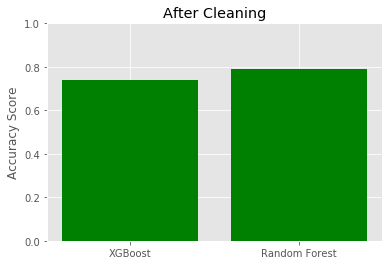

<Figure size 432x288 with 0 Axes>

In [45]:
plt.style.use('ggplot')
plt.bar(['XGBoost', 'Random Forest'],[boost_score, forest_score], color='g')
plt.ylim(0,1)
plt.title('fter Cleaning')
plt.ylabel('Accuracy Score')
fig = plt.figure()
fig.savefig('baseline.jpg')

In [0]:
files.download('baseline.jpg')

In [0]:
example_submission = pd.read_csv('https://raw.githubusercontent.com/PWalis/Unit-2-Project/master/sample_submission.csv')
example_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [0]:
# wrangle the test features and create predictions to format for kaggle submission
test_features = wrangle(test_features)
en_test_features = encoder.fit_transform(test_features)
y_pred = model_2.predict(en_test_features)
y_pred


array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [0]:
submission = example_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission_8.csv', index=False)

In [0]:
submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
from google.colab import files
# files.download('submission_8.csv')

In [31]:
# Hyper param with random forest because it did best
param_distributions = {
    'n_estimators': randint(10, 100), 
    'max_depth': randint(2, 20)
}

search = RandomizedSearchCV(
    estimator=RandomForestClassifier(), 
    param_distributions=param_distributions,
    n_iter=1, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
)

search.fit(en_X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [32]:
# this is the best model from the cross fold validation but it didn't do as well as the default params for random forest
best = search.best_estimator_
test_pred = best.predict(en_X_test)
print(accuracy_score(test_pred, y_test))

0.764983164983165


In [33]:
# !pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='accuracy', cv='prefit', n_iter=2, random_state=42)

permuter.fit(en_X_test, y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=9,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=42,
                                                       n_

In [34]:
# Looking a feature importance to explore wich features to remove
feature_names = en_X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0442 ± 0.0016,quantity
0.0189 ± 0.0062,quantity_group
0.0115 ± 0.0033,waterpoint_type
0.0112 ± 0.0035,extraction_type_class
0.0094 ± 0.0013,construction_year
0.0066 ± 0.0008,payment
0.0063 ± 0.0005,management
0.0056 ± 0.0000,lga
0.0054 ± 0.0008,longitude
0.0038 ± 0.0011,amount_tsh


In [0]:
# Looking at feature importance on the model with the better accuracy score
permuter = PermutationImportance(model_1, scoring='accuracy', cv='prefit', n_iter=2, random_state=42)

permuter.fit(en_X_test, y_test)

feature_names = en_X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0956 ± 0.0056,quantity
0.0549 ± 0.0007,waterpoint_type
0.0156 ± 0.0019,payment_type
0.0156 ± 0.0012,years_service
0.0083 ± 0.0013,extraction_type
0.0059 ± 0.0029,region
0.0040 ± 0.0014,population
0.0027 ± 0.0008,funder
0.0021 ± 0.0000,latitude
0.0018 ± 0.0008,longitude


In [0]:
# Looking at corrilation matrix to find more features to remove
# Also which features to look at for further exploration 
corr_df = en_X_train.corr()
corr_df

,amount_tsh,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,lga,ward,population,public_meeting,recorded_by,scheme_name,extraction_type,management,payment,payment_type,water_quality,quality_group,quantity_group,source,waterpoint_type,waterpoint_type_group
amount_tsh,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gps_height,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installer,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
longitude,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wpt_name,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_private,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subvillage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
